In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import requests
import time
from scipy import signal
from tqdm.notebook import tqdm

In [2]:
url = 'https://static.boredpanda.com/blog/wp-content/uploads/2016/03/hairy-fluffy-cat-sky-the-ragdoll-31.jpg'
im = Image.open(requests.get(url, stream=True).raw)

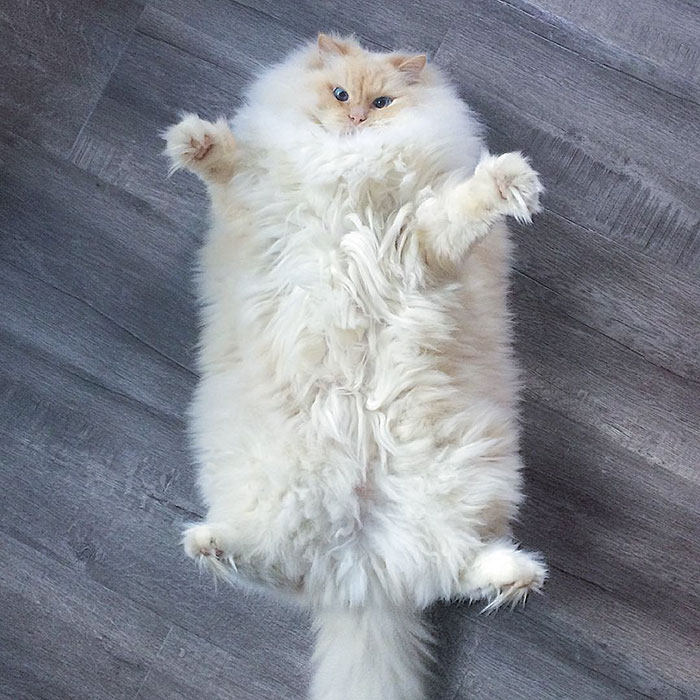

In [3]:
im

In [4]:
def energy_gradient(img):
    height = img.shape[0]
    width = img.shape[1]
    energy = np.empty((height, width))
    for i in range(height):
        for j in range(width):
            L = img[i, (j-1) % width]
            R = img[i, (j+1) % width]
            U = img[(i-1) % height, j]
            D = img[(i+1) % height, j]
            
            dx_sq = np.sum((R - L)**2)
            dy_sq = np.sum((D - U)**2)
            energy[i,j] = np.sqrt(dx_sq + dy_sq)
    return energy

In [5]:
def seams_map_dp(img, energy):
    r, c, _ = img.shape

    M = energy.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 1])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

In [6]:
def carve_column_mask(img, m, backtrack):
    r,c,_ = img.shape
    mask = np.ones((r, c), dtype=np.bool)
    j = np.argmin(m[-1])
    for i in reversed(range(r)):
        mask[i, j] = False
        j = backtrack[i, j]
    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((r, c - 1, 3))
    return img

In [7]:
def seam_carve(img, new_size, energy_function, seam_map_function, carve_function):
    img = np.asarray(img)
    old_range = img.shape[1]
    start_time = time.clock()
    for i in tqdm(range(new_size, old_range)):
        energy = energy_function(img)
        map,backtrack = seam_map_function(img, energy)
        img = carve_function(img, map, backtrack)
    end_time = time.clock()   
    return img, end_time-start_time  

In [8]:
%prun -s cumtime %time res, time_ = seam_carve(im, 650, energy_gradient, seams_map_dp, carve_column_mask)


CPU times: user 9min 7s, sys: 1.15 s, total: 9min 8s
Wall time: 9min 7s
 

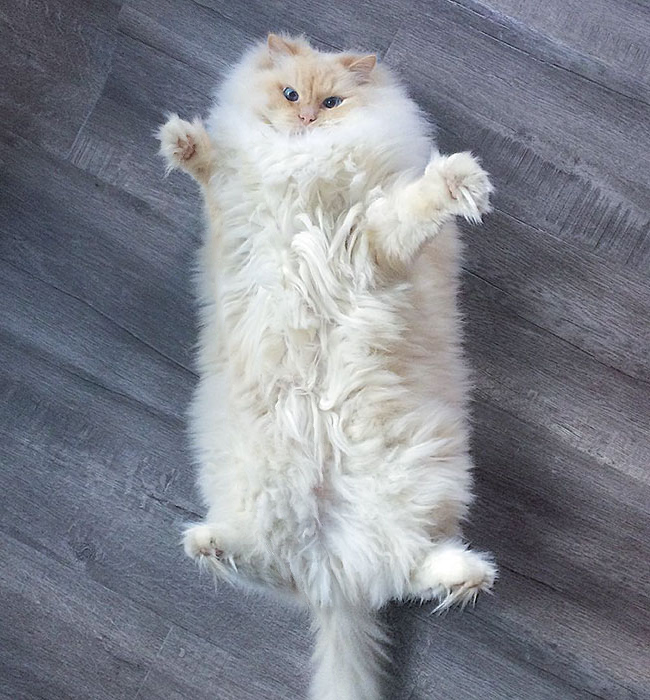

In [9]:
Image.fromarray(res)

In [10]:
def color_to_gray(img):
     return (img[:,:,0] + img[:,:,1] + img[:,:,2])/3.0

In [11]:
def gradient_magnitude_sobel_operator(img):
    image = color_to_gray(img)
    filter = np.array([[1,0,-1],[2,0,-2],[1, 0, -1]])
    new_image_x = signal.convolve2d(image, filter)
    new_image_y = signal.convolve2d(image, np.flip(filter.T, axis=0))
    gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
    gradient_magnitude *= 255.0 / gradient_magnitude.max()
 
    return gradient_magnitude

In [12]:
%prun -s cumtime %time res, time_ = seam_carve(im, 650, gradient_magnitude_sobel_operator, seams_map_dp, carve_column_mask)


CPU times: user 1min 59s, sys: 1.11 s, total: 2min
Wall time: 1min 59s
 

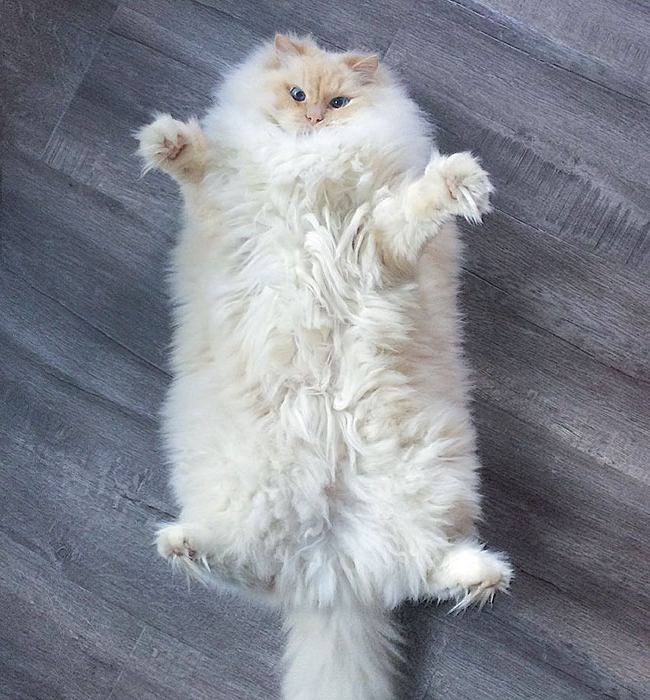

In [13]:
Image.fromarray(res)